# 復習用
#  K-Means++法を実装しよう!

yourKmeas関数をkmeans++で実装してみましょう

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

K-Means法を実装するにあたり、まず1500個のダミーデータを用意します。<br>
__以下のコードを覚える必要はありません！__

Text(0, 0.5, 'Salse')

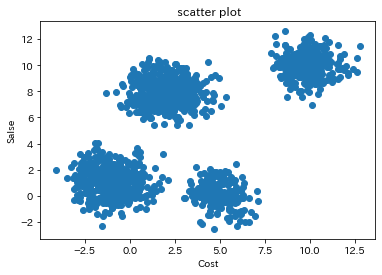

In [2]:
def generate_2dim_normal(mean, variance, covariance, sample_size):
    cov = [[variance,covariance],
           [covariance,variance]]
    return np.random.multivariate_normal(mean, cov, sample_size)

cluster1 = generate_2dim_normal(mean = [2, 8], variance=1, covariance=0, sample_size=500)
cluster2 = generate_2dim_normal(mean = [-1, 1], variance=1, covariance=0, sample_size=500)
cluster3 = generate_2dim_normal(mean = [10, 10], variance=1, covariance=0, sample_size=300)
cluster4 = generate_2dim_normal(mean = [5, 0], variance=0.8, covariance=-0.1, sample_size=200)
data = np.vstack((cluster1, cluster2, cluster3, cluster4))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(data[:,0], data[:,1])
ax.set_title(u" scatter plot")
ax.set_xlabel("Cost")
ax.set_ylabel("Salse")

### クラスタのラベルを取得する関数
あるデータ点に着目した時に、各シード（クラスタの重心）までの距離を計算で求めます。その後に、最も距離が近いクラスタ番号を調べ、そのデータがどのクラスタに属するかを求めます。

【インプット】
- ダミーデータ (data)
- 現在のシードの位置 (center)

【アウトプット】
- 各データ点に対するクラスタのラベル情報 (cluster_labels)

In [3]:
def get_cluster_id_by_euclidian_distance(data, center):
    
    result = np.zeros([len(data), len(center)])
    
    #各データ点から各シード地点までの距離を計算
    for i in range(len(center)):
        square_total = ((data - center[i])**2).sum(axis=1)
        euclidian_distance = np.sqrt(square_total)
        result[:, i] = euclidian_distance
    
    #最も近いクラスタのラベルを取得
    cluster_labels = result.argmin(axis=1)
    return cluster_labels

### クラスタのシード（重心）を更新する関数
クラスタに属するデータ群から重心を計算し、シード位置を更新します。

【インプット】
- 現在の各クラスタのシードの座標 (prev_center)
- 各データ点のクラスタのラベル (cluster_labels)
- クラスタの数 (cluster_num)

【アウトプット】
- 更新後の各クラスタのシードの座標 (new_center)

In [4]:
def update_center(prev_center, cluster_labels, cluster_num):
    new_center = np.zeros(prev_center.shape)
    for i in range(cluster_num):
        new_center[i, :] = data[cluster_labels==i].mean(axis=0)
    return new_center

In [5]:
# 現在のシードをプロットする(デバッグ用)
def plot_center(data, center):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(data[:,0], data[:,1])
    ax.scatter(center[:,0], center[:,1], c='orange')
    ax.set_title(u" scatter plot")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

### kmeansを実行する関数
初期シードを与えることで、kmeansを実行

【インプット】
- 全データ (data)
- シード更新の最大回数 (max_iter)
- 初期シード(複数点)の座標 (init_centers)

【アウトプット】
- 全データに対応するクラスタリング後のラベル一覧 (cluster_labels)

In [6]:
def normal_kmeans(data, max_iter, init_centers, cluster_num):

    centers = init_centers
    # 重心の位置が更新しなくなるまで繰り返す
    for i in range(max_iter):

        # デバッグ用に現在のシードをプロット
        plot_center(data, centers)
        
        # 各サンプルをもとも近いシードと同じクラスターに分類する
        cluster_labels = get_cluster_id_by_euclidian_distance(data, centers)
        
        # クラスターそれぞれで重心（シード）を求める
        new_centers = update_center(centers, cluster_labels, cluster_num)

        # シードが更新されない場合、終了する
        if np.array_equal(new_centers, centers):
            return cluster_labels
        
        # 現在のシードを新たなシードとして更新する
        centers = new_centers
    
    return cluster_labels

### 初期シードとの距離から、重み付き確率分布を用いて新たなシードを求める関数
初期シードを与えることで、新たなシードを求める

【インプット】
- 全データ (data)
- 初期シード(1点)の座標 (init_center)

【アウトプット】
- 新たなシードのインデックス (idx)

In [7]:
def get_seed_from_weight_prob(data, init_center):
    # while k個のクラスタ中心が選ばれるまで do
    ## それぞれのデータ点xに関して、その点の最近傍中心との距離D(x)を計算する。(後に整数のランダム値と比較するため大きな値を乗算)
    square_total = ((data - init_center)**2).sum(axis=1) * 1000
    
    ## データ点xに関して重みつき確率分布{D(x)}^2/sigma{D(x)}^2を用いて、データ点の中から新しいクラスタ中心をランダムに選ぶ。
    
    # 重み配列を降順にソート
    sorted_square_total = np.sort(square_total)[::-1]
    # ソート済みの末尾は、シードinit_centerそのものなので、除外
    sorted_square_total = sorted_square_total[:-1]
    
    # 重みの範囲でランダム値を選択
    np.random.seed()
    rand_val = np.random.randint(sorted_square_total[-1], np.sum(sorted_square_total))
    
    for idx, square in enumerate(sorted_square_total):
        if square >= rand_val:
            return idx
        rand_val -= square
    return -1

### 初期シードを含め、指定数だけシードを求める関数（重み付き確率分布を用いる）

【インプット】
- 全データ (data)
- 初期シード(1点)の座標 (init_center)
- シード数 ※初期シードも含む (cluster_num)

【アウトプット】
- 複数シード (init_centers)

In [8]:
def get_seeds(data, init_center, cluster_num) :
    # クラスタ数-1だけシードを選ぶ(初期シードは1つあるため)
    init_centers = init_center
    for i in range(cluster_num - 1):
        idx_center = get_seed_from_weight_prob(data, init_center)
        init_centers = np.insert(init_centers, 1, data[idx_center], axis=0)
        
    return init_centers

### kmeans++を実行する関数
初期シードを与えることで、kmeansを実行

【インプット】
- 全データ (data)
- シード更新の最大回数 (max_iter)
- シード数 (cluster_num)
- 初期シード(1点)のシード (seed)

【アウトプット】
- 全データに対応するクラスタリング後のラベル一覧 (cluster_labels)

In [9]:
def kmeans_plusplus(data, max_iter, cluster_num, seed):

    # データ点からランダムに1つ選びそれをクラスタ中心とする。
    np.random.seed(seed)
    seed_idx = np.random.randint(len(data), size=1)
    init_center = data[seed_idx]
    
    # 初期シード1つから、重み付き確率分布を用いて、指定数のシードを求める
    init_centers = get_seeds(data, init_center, cluster_num)
    
    # 選ばれたシードを初期値として標準的なk-means法を行う。
    cluster_labels = normal_kmeans(data=data, max_iter=100, init_centers=init_centers, cluster_num=cluster_num)
    return cluster_labels

## kmeans++の実行

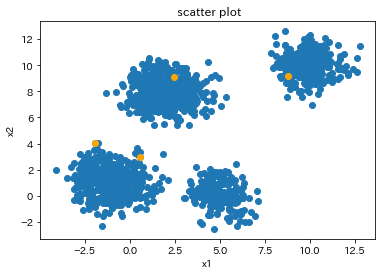

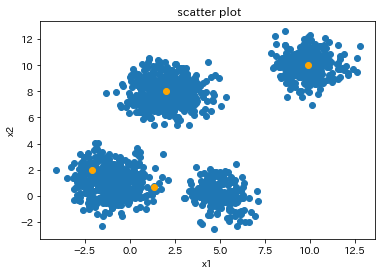

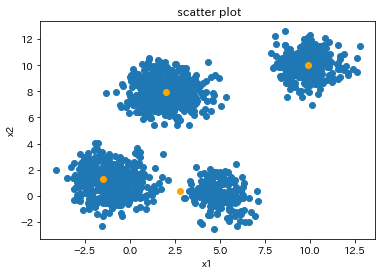

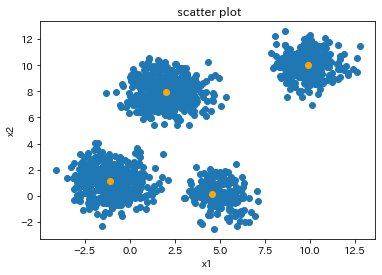

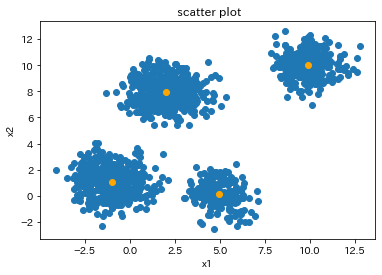

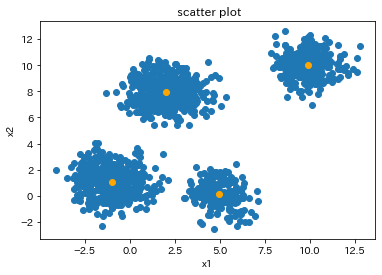

In [10]:
cluster_labels = kmeans_plusplus(data=data, max_iter=100, cluster_num=4, seed=10)

In [11]:
def cluter_visualize(data, cluster_labels):

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
    cluster_ids = list(set(cluster_labels))
    for k in range(len(cluster_ids)):
        cluster_id = cluster_ids[k]
        label_ = "clutser = %d"%cluster_id
        data_by_cluster = data[cluster_labels == cluster_id]
        ax.scatter(data_by_cluster[:,0], data_by_cluster[:,1], c=colorlist[k], label = label_)

    ax.set_title(u"Clustering")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend(loc='lower right')

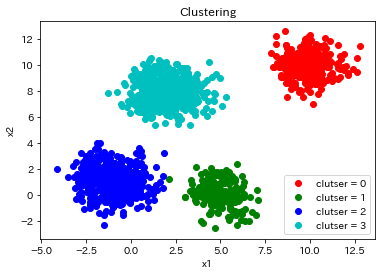

In [12]:
cluter_visualize(data=data, cluster_labels=cluster_labels)